In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/488_research/sbertDf.csv')
df.head()

,text,content_vector
0,Adobe Illustrator is a computer program for ma...,[-2.02746745e-02 -2.02211998e-02 -1.97275840e-...
1,Andouille is a type of pork sausage. It is spi...,[ 1.84027124e-02 4.13582809e-02 -3.38581949e-...
2,"In mathematics, arithmetic is the basic study ...",[-0.03057622 0.00578788 -0.03859627 -0.039436...
3,"Aquaculture is the farming of fish, shrimp, ab...",[ 2.60908678e-02 -3.73822898e-02 7.90265296e-...
4,An Abrahamic Religion is a religion whose foll...,[ 4.24905270e-02 9.78242308e-02 -4.35614213e-...


In [8]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader

fns=['/content/drive/MyDrive/488_research/sbertDf.csv','/content/drive/MyDrive/488_research/mpnetDf.csv']
# fns=['./data/sbertDf.csv','./data/mpnetDf.csv'] #Replace with your data locations
modelNames=['SBERT','MPNet']


sbert=pd.read_csv(fns[0])
sbert['content_vector'] = sbert['content_vector'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))

mpnet=pd.read_csv(fns[1])
mpnet['content_vector'] = mpnet['content_vector'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))

sbert=sbert.rename(columns={"content_vector": "x (sbert)"})
mpnet=mpnet.rename(columns={"content_vector": "y (mpnet)"})
df=mpnet.join(sbert.set_index('text'), on='text')
print(len(df))
df.head()

10000


,text,y (mpnet),x (sbert)
0,Adobe Illustrator is a computer program for ma...,"[0.0086960867, -0.0653527156, -0.0293920096, 0...","[-0.0202746745, -0.0202211998, -0.019727584, 0..."
1,Andouille is a type of pork sausage. It is spi...,"[-0.00322549418, -0.00338032283, 0.0311240926,...","[0.0184027124, 0.0413582809, -0.0338581949, -0..."
2,"In mathematics, arithmetic is the basic study ...","[-0.0192546863, 0.0381052382, -0.00522099249, ...","[-0.03057622, 0.00578788, -0.03859627, -0.0394..."
3,"Aquaculture is the farming of fish, shrimp, ab...","[-0.0120306993, 0.0292836018, -0.0465631112, -...","[0.0260908678, -0.0373822898, 0.00790265296, -..."
4,An Abrahamic Religion is a religion whose foll...,"[-0.00904437155, 0.00528559415, -0.00215970585...","[0.042490527, 0.0978242308, -0.0435614213, 0.0..."


In [29]:
print('x shape', df.head()['y (mpnet)'][0].shape)
print('y shape', df.head()['x (sbert)'][0].shape)


from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)
print('train shape', train.shape)
print('test shape', test.shape)

# Convert data to PyTorch tensors
train_x = torch.tensor(np.vstack(train['x (sbert)'].values), dtype=torch.float32)
train_y = torch.tensor(np.vstack(train['y (mpnet)'].values), dtype=torch.float32)
test_x = torch.tensor(np.vstack(test['x (sbert)'].values), dtype=torch.float32)
test_y = torch.tensor(np.vstack(test['y (mpnet)'].values), dtype=torch.float32)

# Create TensorDataset for training and validation
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

# Create DataLoader for training and validation
batch_size = 128 # You can adjust this batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(test_dataset, batch_size=batch_size)

x shape (768,)
y shape (384,)
train shape (8000, 3)
test shape (2000, 3)


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd

def optimal_clusters(data):
    silhouette_scores = []
    for k in range(2, 5):
        kmeans = KMeans(n_clusters=k, random_state=42,n_init=10)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    optimal_k = np.argmax(silhouette_scores) + 2
    return optimal_k

def cluster_data(data, optimal_k):
    kmeans = KMeans(n_clusters=optimal_k, random_state=42,n_init=10)
    return kmeans.fit_predict(data)

def compute_alignment_score(cluster1, cluster2):
    contingency_matrix = pd.crosstab(cluster1, cluster2)
    alignment_score = contingency_matrix.max(axis=1).sum() / len(cluster1)
    return alignment_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MLP(nn.Module):
    def __init__(self, weight_decay=0.00000, dropout_prob=0.1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features=384, out_features=2048)
        self.fc2 = nn.Linear(in_features=2048, out_features=4096)
        self.fc3 = nn.Linear(in_features=4096, out_features=2048)
        self.fc4 = nn.Linear(in_features=2048, out_features=768)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.weight_decay = weight_decay

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

model = MLP().to(device)  # Move the model to the GPU if available
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=model.weight_decay)

def cosine_similarity_loss(outputs, targets):
    outputs = F.normalize(outputs, p=2, dim=-1)
    targets = F.normalize(targets, p=2, dim=-1)

    # Calculate the cosine similarity
    similarity = torch.sum(outputs * targets, dim=-1)

    loss = 1 - similarity
    return loss.mean()



In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize empty lists to store losses
train_losses = []
val_losses = []
alignment_scores = []  # Add a list to store alignment scores

num_epochs = 200  # You can adjust this

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0  # Initialize a variable to accumulate the train loss
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        # Compute loss
        cosine_loss = cosine_similarity_loss(outputs, targets)
        total_loss = cosine_loss

        # Backpropagation
        total_loss.backward()
        optimizer.step()

        train_loss += total_loss.item()  # Accumulate the train loss for this epoch

    train_losses.append(train_loss / len(train_loader))  # Store average train loss for this epoch



    # Now, you need to calculate validation loss. Assuming you have a val_loader:
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in validation_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            cosine_loss = cosine_similarity_loss(outputs, targets)
            val_loss += cosine_loss.item()

    val_losses.append(val_loss / len(validation_loader))

    print(f"Epoch {epoch}: Train Loss: {train_losses[-1]}, Test Loss: {val_losses[-1]}")

    # After each epoch, perform clustering and compute alignment score
    # if(False):
    if epoch % 20 == 0:
        with torch.no_grad():
            model.eval()
            all_outputs = []
            all_targets = []

            for inputs, targets in train_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                all_outputs.extend(outputs.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

            # Convert to numpy arrays
            all_outputs = np.array(all_outputs)
            all_targets = np.array(all_targets)

            # Find optimal clusters
            optimal_k_outputs = optimal_clusters(all_outputs)
            optimal_k_targets = optimal_clusters(all_targets)
            min_k = min(optimal_k_outputs, optimal_k_targets)

            # Perform clustering
            output_clusters = cluster_data(all_outputs, min_k)
            target_clusters = cluster_data(all_targets, min_k)

            # Compute alignment score
            alignment_score = compute_alignment_score(output_clusters, target_clusters)
            alignment_scores.append(alignment_score)  # Store alignment score for this epoch

            print(f"Epoch {epoch}: Alignment Score: {alignment_scores[-1]}")




Epoch 0: Train Loss: 0.7053504255082872, Test Loss: 0.6433503367006779
Epoch 0: Alignment Score: 0.811875
Epoch 1: Train Loss: 0.6035778796862042, Test Loss: 0.5653697997331619
Epoch 2: Train Loss: 0.5210284548146384, Test Loss: 0.48789307475090027
Epoch 3: Train Loss: 0.4550061784093342, Test Loss: 0.442324860021472
Epoch 4: Train Loss: 0.40855559044414097, Test Loss: 0.4114431906491518
Epoch 5: Train Loss: 0.37283186165113297, Test Loss: 0.39226590655744076
Epoch 6: Train Loss: 0.34336951185786535, Test Loss: 0.37829057313501835
Epoch 7: Train Loss: 0.3188445946526906, Test Loss: 0.36981718614697456
Epoch 8: Train Loss: 0.29728188685008455, Test Loss: 0.3621507305651903
Epoch 9: Train Loss: 0.2782512292975471, Test Loss: 0.35887948237359524
Epoch 10: Train Loss: 0.2611127235586681, Test Loss: 0.35711980424821377
Epoch 11: Train Loss: 0.2464611322160751, Test Loss: 0.35389682091772556
Epoch 12: Train Loss: 0.23271542882162427, Test Loss: 0.35279502905905247
Epoch 13: Train Loss: 0.220

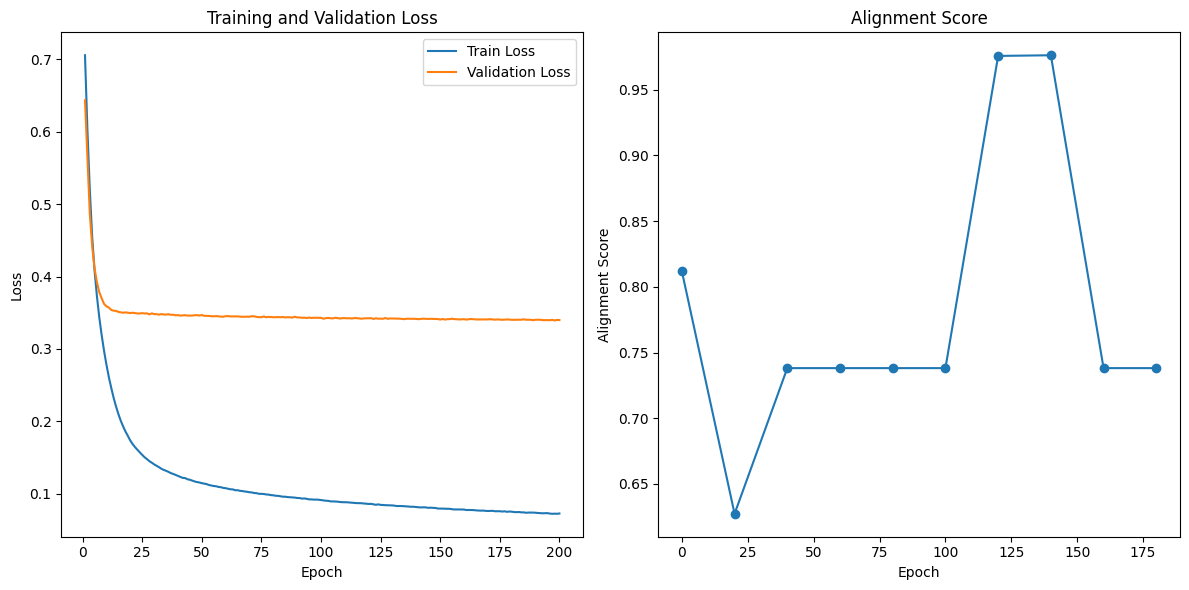

In [34]:
# Plot the losses and alignment scores
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(0,200,20),alignment_scores, marker='o', linestyle='-')
plt.title('Alignment Score')
plt.xlabel('Epoch')
plt.ylabel('Alignment Score')

plt.tight_layout()
plt.show()